In [9]:
import argparse
import torch
torch.cuda.set_device(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchvision import datasets, transforms
from torchtext import data
from torchtext import datasets
from torchtext.vocab import Vectors, GloVe, CharNGram, FastText
from RNN import Model
from Train import Train
from Test import Test
import easydict 

In [10]:
args = easydict.EasyDict({
    "batch_size": 128,
    "epochs": 50,
    "lr": 0.005,
    "weight_decay":0.00001,
    "momentum": 0.9,
    "no_cuda": False,
    "seed": 1,
    "log-interval":10
    
})

In [11]:
criterion = nn.CrossEntropyLoss()  
criterion.cuda()

#args = parser.parse_args()

use_cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
device = torch.device("cuda" if use_cuda else "cpu")

In [13]:

TEXT = data.Field()
LABEL = data.Field(sequential=False,dtype=torch.long)

train, val, test = datasets.SST.splits(
    TEXT, LABEL, fine_grained=True, train_subtrees=False)

# print information about the data
print('train.fields', train.fields)
print('len(train)', len(train))
print('vars(train[0])', vars(train[0]))


TEXT.build_vocab(train, vectors=torchtext.vocab.Vectors("glove.6B.300d.txt", cache='./data'), max_size=20000)
LABEL.build_vocab(train)

print(TEXT.vocab.itos[:10])
print(LABEL.vocab.stoi)
print(TEXT.vocab.freqs.most_common(20))

# print vocab information
print('len(TEXT.vocab)', len(TEXT.vocab))
print('TEXT.vocab.vectors.size()', TEXT.vocab.vectors.size())

# make iterator for splits
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train, val, test), batch_size=args.batch_size)

# print batch information
batch = next(iter(train_iter)) # for batch in train_iter
print(batch.text) # input sequence
print(batch.label) # groud truth

pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)
shape = pretrained_embeddings.shape

model = Model(shape[1],shape[0],256)
model.cuda()
print(model)
model.embedding.weight.data.copy_(pretrained_embeddings)


train.fields {'text': <torchtext.data.field.Field object at 0x7fb7b4e3b908>, 'label': <torchtext.data.field.Field object at 0x7fb7b4e3b940>}
len(train) 8544
vars(train[0]) {'text': ['The', 'Rock', 'is', 'destined', 'to', 'be', 'the', '21st', 'Century', "'s", 'new', '``', 'Conan', "''", 'and', 'that', 'he', "'s", 'going', 'to', 'make', 'a', 'splash', 'even', 'greater', 'than', 'Arnold', 'Schwarzenegger', ',', 'Jean-Claud', 'Van', 'Damme', 'or', 'Steven', 'Segal', '.'], 'label': 'positive'}
['<unk>', '<pad>', '.', ',', 'the', 'and', 'a', 'of', 'to', "'s"]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7fb7b4e3b9e8>>, {'<unk>': 0, 'positive': 1, 'negative': 2, 'neutral': 3, 'very positive': 4, 'very negative': 5})
[('.', 8024), (',', 7131), ('the', 6037), ('and', 4431), ('a', 4403), ('of', 4386), ('to', 2995), ("'s", 2544), ('is', 2536), ('that', 1915), ('in', 1789), ('it', 1775), ('The', 1265), ('as', 1200), ('film', 1152), ('but', 1076), ('with'

tensor([[ 0.4292, -0.2969,  0.1501,  ...,  0.2898,  0.3262, -0.0591],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],
        ...,
        [-0.0244, -1.1009, -0.4874,  ..., -0.2397,  0.8099,  0.6723],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.3162,  0.1013,  0.4133,  ...,  0.2767,  0.2660, -0.6653]],
       device='cuda:0')

In [121]:
Loss_001 =[]
Acc_001 = []
Loss_005 =[]
Acc_005 = []
Loss_01 =[]
Acc_01 = []

In [136]:
#Training Testing

optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
print("Start Training:")
for epoch in range(args.epochs):
    Train(args, model, device, train_iter, optimizer, epoch,criterion)
    loss, acc = Test(args, model, device, test_iter,criterion)
    Loss_005.append(loss)
    Acc_005.append(acc)

def cut(a,n):
    return [sum(a[i:i+n])/n for i in range(0,len(a),n)]

Loss_005 = cut(Loss_005,5)
Acc_005 = cut(Acc_005,5)

print("FINISHED")
print("Loss_005:")
print(Loss_005)
print("Acc_005") 
print(Acc_005)
    


Start Training:
Train Epoch: 0	Loss: 1.583908

Test set: Average loss: 1.5821, Accuracy: 507/2304 (22.0052%)

Train Epoch: 1	Loss: 1.582137

Test set: Average loss: 1.5778, Accuracy: 530/2304 (23.0035%)

Train Epoch: 2	Loss: 1.551615

Test set: Average loss: 1.5769, Accuracy: 550/2304 (23.8715%)

Train Epoch: 3	Loss: 1.575435

Test set: Average loss: 1.5752, Accuracy: 604/2304 (26.2153%)

Train Epoch: 4	Loss: 1.508526

Test set: Average loss: 1.5729, Accuracy: 651/2304 (28.2552%)

Train Epoch: 5	Loss: 1.566498

Test set: Average loss: 1.5724, Accuracy: 611/2304 (26.5191%)

Train Epoch: 6	Loss: 1.537741

Test set: Average loss: 1.5704, Accuracy: 652/2304 (28.2986%)

Train Epoch: 7	Loss: 1.571637

Test set: Average loss: 1.5690, Accuracy: 646/2304 (28.0382%)

Train Epoch: 8	Loss: 1.528155

Test set: Average loss: 1.5666, Accuracy: 671/2304 (29.1233%)

Train Epoch: 9	Loss: 1.562575

Test set: Average loss: 1.5650, Accuracy: 654/2304 (28.3854%)

Train Epoch: 10	Loss: 1.563347

Test set: Av

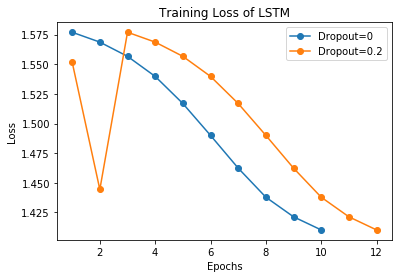

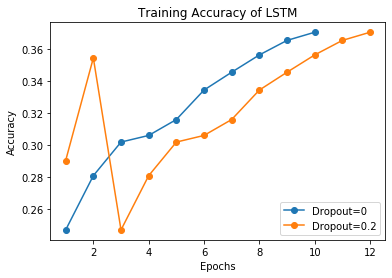

In [137]:
# Dropout compare

#Learning rate compare
#with max
import matplotlib.pyplot as plt

figure1,bx = plt.subplots()
bx.plot([None]+Loss_001, 'o-',label='Dropout=0')
bx.plot([None]+Loss_005, 'o-',label='Dropout=0.2')
bx.set_title('Training Loss of LSTM')
bx.set_xlabel('Epochs')
bx.set_ylabel('Loss')
bx.legend(loc="upper right")

figure,cx = plt.subplots()
cx.plot([None]+Acc_001,'o-',label='Dropout=0')
cx.plot([None]+Acc_005,'o-',label='Dropout=0.2')
cx.set_title('Training Accuracy of LSTM')
cx.set_xlabel('Epochs')
cx.set_ylabel('Accuracy')
cx.legend(loc="lower right")

In [138]:
#one layer values droput =0.5, 256
print("L005=",Loss_005)
print("L001=",Loss_001)

print("A005=",Acc_005)
print("A001=",Acc_001)

L005= [1.5517980511983236, 1.4443325702349346, 1.5770047187805178, 1.5686767008569507, 1.5566789759529962, 1.5397492527961731, 1.5168806076049803, 1.4899794419606527, 1.4623574203915066, 1.4378277222315472, 1.4212847577200995, 1.4102135088708665]
L001= [1.5770047187805178, 1.5686767008569507, 1.5566789759529962, 1.5397492527961731, 1.5168806076049803, 1.4899794419606527, 1.4623574203915066, 1.4378277222315472, 1.4212847577200995, 1.4102135088708665]
A005= [0.29024305555555563, 0.3546006944444444, 0.24670138888888887, 0.28072916666666664, 0.3018229166666667, 0.30598958333333337, 0.3159722222222222, 0.33446180555555555, 0.34565972222222224, 0.35651041666666666, 0.365625, 0.3707465277777778]
A001= [0.24670138888888887, 0.28072916666666664, 0.3018229166666667, 0.30598958333333337, 0.3159722222222222, 0.33446180555555555, 0.34565972222222224, 0.35651041666666666, 0.365625, 0.3707465277777778]


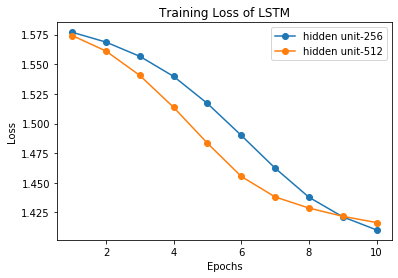

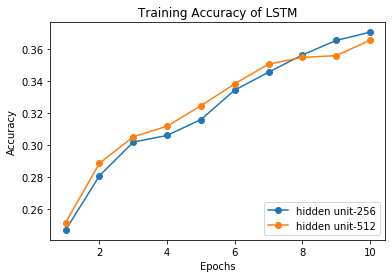

In [63]:
# Hidden unit compare

#Learning rate compare
#with max
import matplotlib.pyplot as plt

figure1,bx = plt.subplots()
bx.plot([None]+Loss_001, 'o-',label='hidden unit-256')
bx.plot([None]+Loss_005, 'o-',label='hidden unit-512')
bx.set_title('Training Loss of LSTM')
bx.set_xlabel('Epochs')
bx.set_ylabel('Loss')
bx.legend(loc="upper right")

figure,cx = plt.subplots()
cx.plot([None]+Acc_001,'o-',label='hidden unit-256')
cx.plot([None]+Acc_005,'o-',label='hidden unit-512')
cx.set_title('Training Accuracy of LSTM')
cx.set_xlabel('Epochs')
cx.set_ylabel('Accuracy')
cx.legend(loc="lower right")



In [62]:
#one layer values droput =0.5, 256
print("L005=",Loss_005)
print("L001=",Loss_001)

print("A005=",Acc_005)
print("A001=",Acc_001)

L005= [1.574229717254639, 1.5611366748809814, 1.5405744009547764, 1.5136360711521573, 1.4833661688698663, 1.4553632338841758, 1.4380655659569634, 1.4286759946081373, 1.4217045346895854, 1.4164154900444879]
L001= [1.5770047187805178, 1.5686767008569507, 1.5566789759529962, 1.5397492527961731, 1.5168806076049803, 1.4899794419606527, 1.4623574203915066, 1.4378277222315472, 1.4212847577200995, 1.4102135088708665]
A005= [0.25130208333333337, 0.2885416666666667, 0.3051215277777778, 0.31180555555555556, 0.3246527777777778, 0.3383680555555556, 0.35078125, 0.35494791666666664, 0.3560763888888888, 0.3657118055555556]
A001= [0.24670138888888887, 0.28072916666666664, 0.3018229166666667, 0.30598958333333337, 0.3159722222222222, 0.33446180555555555, 0.34565972222222224, 0.35651041666666666, 0.365625, 0.3707465277777778]


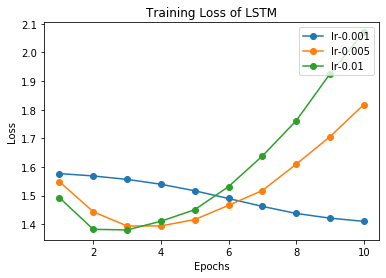

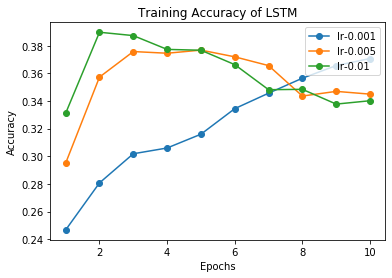

In [49]:

#Learning rate compare
#with max
import matplotlib.pyplot as plt

figure1,bx = plt.subplots()
bx.plot([None]+Loss_001, 'o-',label='lr-0.001')
bx.plot([None]+Loss_005, 'o-',label='lr-0.005')
bx.plot([None]+Loss_01,'o-', label='lr-0.01')

bx.set_title('Training Loss of LSTM')
bx.set_xlabel('Epochs')
bx.set_ylabel('Loss')
bx.legend(loc="upper right")

figure,cx = plt.subplots()
cx.plot([None]+Acc_001,'o-',label='lr-0.001')
cx.plot([None]+Acc_005,'o-',label='lr-0.005')
cx.plot([None]+Acc_01,'o-',label='lr-0.01')
cx.set_title('Training Accuracy of LSTM')
cx.set_xlabel('Epochs')
cx.set_ylabel('Accuracy')
cx.legend(loc="upper right")



In [48]:
#one layer values droput =0.5, 256
print("L005=",Loss_005)
print("L001=",Loss_001)
print("L01=",Loss_01)

print("A005=",Acc_005)
print("A001=",Acc_001)
print("A01=",Acc_01)

L005= [1.548728048801422, 1.4437446329328747, 1.3938623494572109, 1.3941912518607247, 1.4162663605478074, 1.4660477187898424, 1.5178024782074822, 1.6094792207082111, 1.7058927284346688, 1.8179080804189045]
L001= [1.5770047187805178, 1.5686767008569507, 1.5566789759529962, 1.5397492527961731, 1.5168806076049803, 1.4899794419606527, 1.4623574203915066, 1.4378277222315472, 1.4212847577200995, 1.4102135088708665]
L01= [1.492877447605133, 1.3822355349858602, 1.3802047888437905, 1.41043844487932, 1.4507074819670784, 1.5314055932892694, 1.6381925331221687, 1.7614325669076707, 1.92506103515625, 2.0705746478504605]
A005= [0.2950520833333333, 0.3572916666666667, 0.37578125, 0.3745659722222222, 0.3768229166666667, 0.3719618055555555, 0.365625, 0.34357638888888886, 0.34696180555555556, 0.34496527777777775]
A001= [0.24670138888888887, 0.28072916666666664, 0.3018229166666667, 0.30598958333333337, 0.3159722222222222, 0.33446180555555555, 0.34565972222222224, 0.35651041666666666, 0.365625, 0.370746527